# Model Training

Zur Klassifizierung gibt es verschiedene Algorithmen und Methoden. In dieser Arbeit werden drei verschiedene Methoden evaluiert. So soll herausgefunden werden, welches Modell die beste Performance auf den vorliegenden Daten aufweißt. Außerdem werden die Methoden mit einem geeigneten Baseline Clasifier verglichen.
Die zu vergleichenden Modelle sind
 - Support Vector Machine (SVM)
 - Multinomial Naïve Bayes
 - k-Nearest Neighbors
 
 Für die Evaluierung wird folgendes Vorgehen für jeden Algorithmus durchlaufen:
 1. Zuerst werden fie zu tunenden Hyperparameter für das Modell gewählt
 2. Definition der Metrik, welche für die Messung der Modell-Performance und zur Durchführung des Vergleichs angewendet wird. In diesem Fall wird die **Genauigkeit(accuracy)** gewählt.
 3. ...

## 1 Baseline Classifier
Ein geeigneter Baseline Classifier soll der Überprüfung dienen, ob brauchbare Modelle erzeugt werden. Ein Baseline Classifier, welcher bei jeder Klassifizierung die am häufigsten vertretene Klasse (AfD mit 18 von 78 Dokumenten) zurückgibt, wäre ein geeigneter und einfacher Vergleichswert.
Die im Korpus am häufigsten vertretene Klasse repräsentiert **23%** des gesamten Datensatzes. Aus diesem Grund wäre dies die Genauigkeit des Baseline Classifiers. Mit diesem werden die erzeugten Modelle verglichen.   

In [269]:
import pickle
import numpy as np
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

model_summary_df = pd.DataFrame()

Zuerst werden die zuvor generierten Daten geladen

In [270]:
# Programs Dataframe
path_df = "Pickles/programs_df.pickle"
with open(path_df, 'rb') as data:
    programs_df = pickle.load(data)

# features_train
path_features_train = "Pickles/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "Pickles/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "Pickles/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "Pickles/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

## 2 Support Vector Machine

Bisschen bla bla über SVM

### Hyperparameter Tuning mittles Cross Validation

Hier wird nicht auf die Funktionsweise von SVM eingegangen. Hier ist die Beschreibung: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [272]:
svc_init = svm.SVC(random_state=123)

print('Aktuell genutzte Parameter:\n')
pprint(svc_init.get_params())

Aktuell genutzte Parameter:

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 123,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


Schreiben was die Parameter bringen und welche wir tunen (C, kernel, gamma, degree)

### Randomized Search Cross-Validation

In [273]:
# C
C = [.0001, .001, .01]

# gamma
gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree
degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True]

# Create the random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)

{'C': [0.0001, 0.001, 0.01],
 'degree': [1, 2, 3, 4, 5],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'kernel': ['linear', 'rbf', 'poly'],
 'probability': [True]}


In [274]:
# First create the base model to tune
svc = svm.SVC(random_state=123)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=123)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    5.3s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=123,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=50, n_jobs=None,
                   param_distributions={'C': [0.0001, 0.001, 0.01],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'probability': [True]},
                   pre_dispatch='2*n_jobs', random

In [275]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'probability': True, 'kernel': 'poly', 'gamma': 100, 'degree': 4, 'C': 0.01}

The mean accuracy of a model with these hyperparameters is:
0.9841269841269842


### Grid Search Cross Validation

In [276]:
# Create the parameter grid based on the results of random search 
C = [.0001, .001, .01, .1]
degree = [3, 4, 5]
gamma = [1, 10, 100]
probability = [True]

param_grid = [
  {'C': C, 'kernel':['linear'], 'probability':probability},
  {'C': C, 'kernel':['poly'], 'degree':degree, 'probability':probability, 'gamma':gamma},
  {'C': C, 'kernel':['rbf'], 'gamma':gamma, 'probability':probability}
]

# Create a base model
svc = svm.SVC(random_state=123)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 123)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 52 candidates, totalling 156 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 156 out of 156 | elapsed:    5.8s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=123, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=123, shrinking=True,
                           tol=0.001, verbose=False),
             iid='depreca...
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear'],
                          'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1], 'degree': [3, 4, 5],
                          'gamma': [1, 10, 100], 'kernel': ['poly'],
                          'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1],
                          'gamma': [1, 10, 100], 'kernel': ['rb

In [277]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.0001, 'degree': 3, 'gamma': 100, 'kernel': 'poly', 'probability': True}

The mean accuracy of a model with these hyperparameters is:
0.8730158730158729


In [278]:
best_svc = grid_search.best_estimator_
best_svc

SVC(C=0.0001, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100, kernel='poly',
    max_iter=-1, probability=True, random_state=123, shrinking=True, tol=0.001,
    verbose=False)

### Model fit and performance

In [279]:
best_svc.fit(features_train, labels_train)

SVC(C=0.0001, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100, kernel='poly',
    max_iter=-1, probability=True, random_state=123, shrinking=True, tol=0.001,
    verbose=False)

In [280]:
svc_pred = best_svc.predict(features_test)
print(svc_pred)

[3 4 4 0 3 1 5 1 0 4 0 4 2 1 4 4]


In [281]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_svc.predict(features_train)))

The training accuracy is: 
1.0


In [282]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, svc_pred))

The test accuracy is: 
0.9375


In [283]:
# Classification report
print("Classification report")
print(classification_report(labels_test,svc_pred))

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.67      1.00      0.80         2
           2       1.00      1.00      1.00         1
           3       1.00      0.67      0.80         3
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         1

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.93        16
weighted avg       0.96      0.94      0.94        16



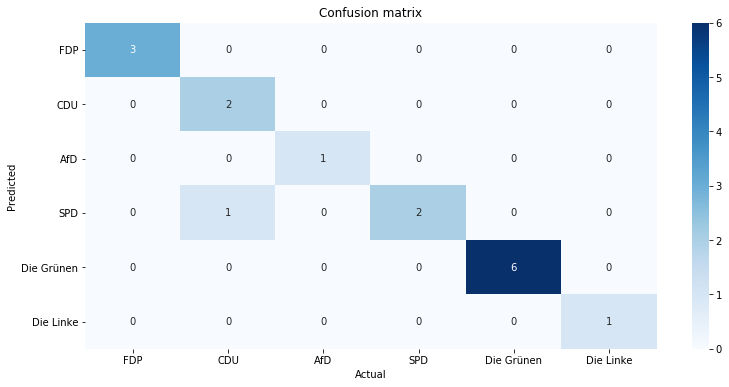

In [284]:
aux_df = programs_df[['party', 'party_code']].drop_duplicates().sort_values('party_code')
conf_matrix = confusion_matrix(labels_test, svc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['party'].values, 
            yticklabels=aux_df['party'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()


In [285]:
# base model
base_model = svm.SVC(random_state = 123)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.8125

In [286]:
best_svc.fit(features_train, labels_train)
accuracy_score(labels_test, best_svc.predict(features_test))

0.9375

In [287]:
data = {
     'Model': 'SVM',
     'Training Set Accuracy': accuracy_score(labels_train, best_svc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, svc_pred)
}

models_df_svc = pd.DataFrame(data, index=[0])
model_summary_df = model_summary_df.append(models_df_svc)
models_df_svc

,Model,Training Set Accuracy,Test Set Accuracy
0,SVM,1.0,0.9375


In [288]:
with open('Models/best_svc.pickle', 'wb') as output:
    pickle.dump(best_svc, output)
    
with open('Models/models_df_svc.pickle', 'wb') as output:
    pickle.dump(models_df_svc, output)

## 3 Multinomial Naïve Bayes

Bisschen bla bla

### Hyperparameter Tuning mittles Cross Validation

Bei dem Multinomial Naïve Bayes Model werden keine parameter getuned.

In [289]:
mnbc = MultinomialNB()
mnbc

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Model fit and performance

Now, we can fit the model to our training data.

In [290]:
mnbc.fit(features_train, labels_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [291]:
mnbc_pred = mnbc.predict(features_test)
print(mnbc_pred)

[2 2 4 2 2 2 2 0 2 4 0 2 2 2 2 4]


In [292]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, mnbc.predict(features_train)))

The training accuracy is: 
0.6935483870967742


In [293]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, mnbc_pred))

The test accuracy is: 
0.3125


In [294]:
# Classification report
print("Classification report")
print(classification_report(labels_test,mnbc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.00      0.00      0.00         2
           2       0.09      1.00      0.17         1
           3       0.00      0.00      0.00         3
           4       1.00      0.50      0.67         6
           5       0.00      0.00      0.00         1

    accuracy                           0.31        16
   macro avg       0.27      0.31      0.21        16
weighted avg       0.47      0.31      0.34        16



/Users/basti/opt/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


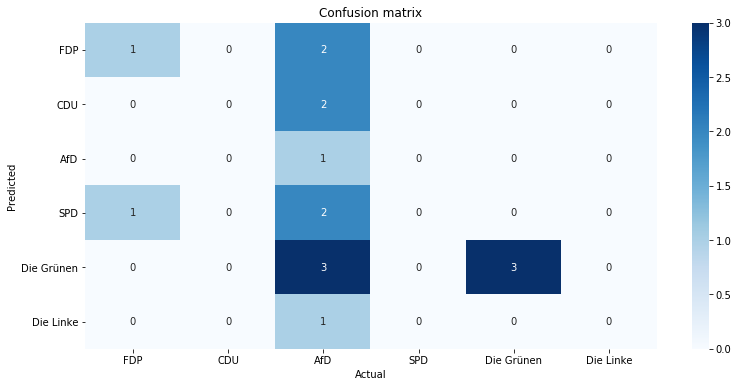

In [295]:
aux_df = programs_df[['party', 'party_code']].drop_duplicates().sort_values('party_code')
conf_matrix = confusion_matrix(labels_test, mnbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['party'].values, 
            yticklabels=aux_df['party'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [296]:
data = {
     'Model': 'Multinomial Naïve Bayes',
     'Training Set Accuracy': accuracy_score(labels_train, mnbc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, mnbc_pred)
}

models_df_mnbc = pd.DataFrame(data, index=[0])
model_summary_df = model_summary_df.append(models_df_mnbc)
models_df_mnbc

,Model,Training Set Accuracy,Test Set Accuracy
0,Multinomial Naïve Bayes,0.693548,0.3125


In [297]:
with open('Models/best_mnbc.pickle', 'wb') as output:
    pickle.dump(mnbc, output)
    
with open('Models/df_models_mnbc.pickle', 'wb') as output:
    pickle.dump(models_df_mnbc, output)

## 4 k-Nearest Neighbors

bisschen bla bla 

### Hyperparameter Tuning mittles Cross Validation

In [298]:
knnc_init =KNeighborsClassifier()

print('Parameters currently in use:\n')
pprint(knnc_init.get_params())

Parameters currently in use:

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


We'll tune the following ones:
n_neighbors: Number of neighbors to use by default for queries.
In this case, since there is only one hyperparameter, we'll perform an exhaustive search directly:

### Grid Search Cross Validation

In [299]:
# Create the parameter grid 
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 41, num = 41)]

param_grid = {'n_neighbors': n_neighbors}

# Create a base model
knnc = KNeighborsClassifier()

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 123)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 41 candidates, totalling 123 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 123 out of 123 | elapsed:    0.6s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=123, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [300]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 1}

The mean accuracy of a model with these hyperparameters is:
0.888888888888889


In [301]:
best_knnc = grid_search.best_estimator_
best_knnc

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

### Model fit and performance

In [302]:
best_knnc.fit(features_train, labels_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [303]:
knnc_pred = best_knnc.predict(features_test)
print(knnc_pred)

[3 4 4 0 3 1 5 4 0 4 0 3 2 1 4 4]


In [304]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_knnc.predict(features_train)))

The training accuracy is: 
1.0


In [305]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, knnc_pred))

The test accuracy is: 
0.875


In [306]:
# Classification report
print("Classification report")
print(classification_report(labels_test,knnc_pred))

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       0.67      0.67      0.67         3
           4       0.83      0.83      0.83         6
           5       1.00      1.00      1.00         1

    accuracy                           0.88        16
   macro avg       0.92      0.92      0.92        16
weighted avg       0.88      0.88      0.88        16



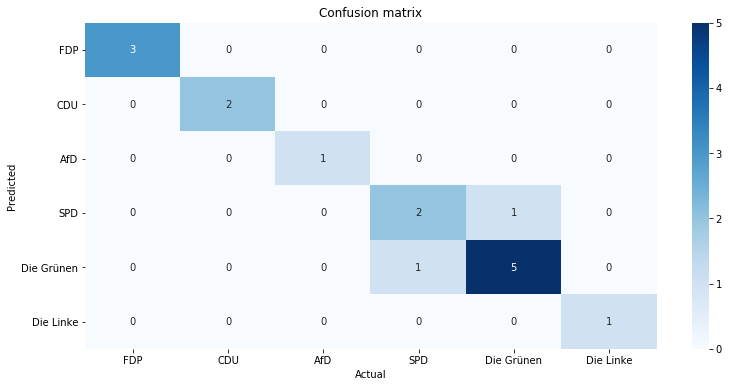

In [307]:
aux_df = programs_df[['party', 'party_code']].drop_duplicates().sort_values('party_code')
conf_matrix = confusion_matrix(labels_test, knnc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['party'].values, 
            yticklabels=aux_df['party'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [308]:
base_model = KNeighborsClassifier()
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9375

In [309]:
best_knnc.fit(features_train, labels_train)
accuracy_score(labels_test, best_knnc.predict(features_test))

0.875

In [310]:
data = {
     'Model': 'KNN',
     'Training Set Accuracy': accuracy_score(labels_train, best_knnc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, knnc_pred)
}

models_df_knnc = pd.DataFrame(data, index=[0])
model_summary_df = model_summary_df.append(models_df_knnc)
models_df_knnc

,Model,Training Set Accuracy,Test Set Accuracy
0,KNN,1.0,0.875


In [311]:
with open('Models/best_knnc.pickle', 'wb') as output:
    pickle.dump(best_knnc, output)

with open('Models/models_df_knnc.pickle', 'wb') as output:
    pickle.dump(models_df_knnc, output)

## 5 Logistic Regression

hier bisschen bla bla

### Hyperparameter Tuning mittles Cross Validation

In [312]:
lr_init = LogisticRegression(random_state = 123)

print('Parameters currently in use:\n')
pprint(lr_init.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 123,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


We'll tune the following ones:
C = Inverse of regularization strength. Smaller values specify stronger regularization.
multi_class = We'll choose multinomial because this is a multi-class problem.
solver = Algorithm to use in the optimization problem. For multiclass problems, only newton-cg, sag, saga and lbfgs handle multinomial loss.
class_weight: Weights associated with classes.
penalty: Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties.We'll tune the following ones:
C = Inverse of regularization strength. Smaller values specify stronger regularization.
multi_class = We'll choose multinomial because this is a multi-class problem.
solver = Algorithm to use in the optimization problem. For multiclass problems, only newton-cg, sag, saga and lbfgs handle multinomial loss.
class_weight: Weights associated with classes.
penalty: Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties.

### Randomized Search Cross Validation

In [313]:
# C
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]

# multi_class
multi_class = ['multinomial']

# solver
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
# class_weight
class_weight = ['balanced', None]

# penalty
penalty = ['l2']

# Create the random grid
random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

pprint(random_grid)

{'C': [0.1,
       0.2,
       0.30000000000000004,
       0.4,
       0.5,
       0.6,
       0.7000000000000001,
       0.8,
       0.9,
       1.0],
 'class_weight': ['balanced', None],
 'multi_class': ['multinomial'],
 'penalty': ['l2'],
 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}


In [314]:
# First create the base model to tune
lrc = LogisticRegression(random_state=123)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=123)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    6.4s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=123,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=50, n_jobs=None,
                   param_distributions={'C': [0.1, 0.2, 0.30000000000000004,
                                              0.4, 0.5, 0.6, 0.7000000000000001,
                                              0.8, 0.9, 1.0],
                                        'class_weight': ['bala

In [315]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': 'balanced', 'C': 0.9}

The mean accuracy of a model with these hyperparameters is:
0.9841269841269842


### Grid Search Cross Validation

In [316]:
# Create the parameter grid based on the results of random search 
C = [float(x) for x in np.linspace(start = 0.6, stop = 1, num = 10)]
multi_class = ['multinomial']
solver = ['newton-cg']
class_weight = ['balanced']
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

# Create a base model
lrc = LogisticRegression(random_state=123)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 123)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.8s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=123, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=123, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),...
             param_grid={'C': [0.6, 0.6444444444444444, 0.6888888888888889,
                               0.7333333333333333, 0.7777777777777778,
                               0.8222222222222222, 0.8666666666666667,
                               0.9111111111111111, 0.9555555555555555, 1.0],
            

In [317]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.6, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg'}

The mean accuracy of a model with these hyperparameters is:
0.9523809523809524


In [318]:
best_lrc = grid_search.best_estimator_
best_lrc

LogisticRegression(C=0.6, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=123, solver='newton-cg',
                   tol=0.0001, verbose=0, warm_start=False)

### Model fit and performance

In [319]:
best_lrc.fit(features_train, labels_train)

LogisticRegression(C=0.6, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=123, solver='newton-cg',
                   tol=0.0001, verbose=0, warm_start=False)

In [320]:
lrc_pred = best_lrc.predict(features_test)

In [321]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_lrc.predict(features_train)))

The training accuracy is: 
1.0


In [322]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, lrc_pred))

The test accuracy is: 
1.0


In [323]:
# Classification report
print("Classification report")
print(classification_report(labels_test,lrc_pred))

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         1

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



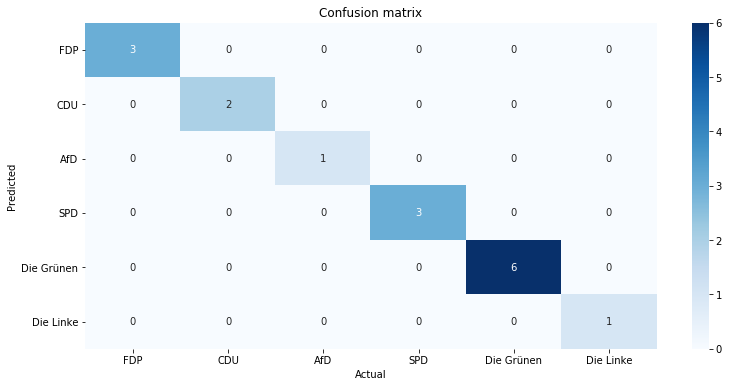

In [324]:
aux_df = programs_df[['party', 'party_code']].drop_duplicates().sort_values('party_code')
conf_matrix = confusion_matrix(labels_test, lrc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['party'].values, 
            yticklabels=aux_df['party'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [325]:
base_model = LogisticRegression(random_state = 123)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.6875

In [326]:
best_lrc.fit(features_train, labels_train)
accuracy_score(labels_test, best_lrc.predict(features_test))

1.0

In [327]:
data = {
     'Model': 'Logistic Regression',
     'Training Set Accuracy': accuracy_score(labels_train, best_lrc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, lrc_pred)
}

models_df_lrc = pd.DataFrame(data, index=[0])
model_summary_df = model_summary_df.append(models_df_lrc)
models_df_lrc

,Model,Training Set Accuracy,Test Set Accuracy
0,Logistic Regression,1.0,1.0


In [328]:
with open('Models/best_lrc.pickle', 'wb') as output:
    pickle.dump(best_lrc, output)
    
with open('Models/models_df_lrc.pickle', 'wb') as output:
    pickle.dump(models_df_lrc, output)

## 6 Gradient Boost

bisschen bla bla

### Hyperparameter Tuning mittles Cross Validation

In [329]:
gb_init = GradientBoostingClassifier(random_state = 123)

print('Parameters currently in use:\n')
pprint(gb_init.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 123,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


We'll tune the following ones:
Tree-related hyperparameters:
n_estimators = number of trees in the forest.
max_features = max number of features considered for splitting a node
max_depth = max number of levels in each decision tree
min_samples_split = min number of data points placed in a node before the node is split
min_samples_leaf = min number of data points allowed in a leaf node
Boosting-related hyperparameters:
learning_rate= learning rate shrinks the contribution of each tree by learning_rate.
subsample= the fraction of samples to be used for fitting the individual base learners.

### Randomized Search Cross Validation

In [330]:
# n_estimators
n_estimators = [200, 800]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [10, 40]
max_depth.append(None)

# min_samples_split
min_samples_split = [10, 30, 50]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# learning rate
learning_rate = [.1, .5]

# subsample
subsample = [.5, 1.]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate,
               'subsample': subsample}

pprint(random_grid)

{'learning_rate': [0.1, 0.5],
 'max_depth': [10, 40, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [10, 30, 50],
 'n_estimators': [200, 800],
 'subsample': [0.5, 1.0]}


In [331]:
# First create the base model to tune
gbc = GradientBoostingClassifier(random_state=123)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=gbc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=123)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  5.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [237]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'subsample': 0.5, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'learning_rate': 0.1}

The mean accuracy of a model with these hyperparameters is:
0.9682539682539683


### Grid Search Cross Validation

In [238]:
# Create the parameter grid based on the results of random search 
max_depth = [25, 30, 35, 40]
max_features = ['auto']
min_samples_leaf = [1]
min_samples_split = [5, 10, 15]
n_estimators = [200]
learning_rate = [.1, .5]
subsample = [.5]

param_grid = {
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'subsample': subsample

}

# Create a base model
gbc = GradientBoostingClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=gbc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  2.1min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samp...
                                                  validation_fraction=0.1,
                                                  verbose=0, warm_start=False),

In [239]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'learning_rate': 0.1, 'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.5}

The mean accuracy of a model with these hyperparameters is:
0.9523809523809524


In [240]:
best_gbc = grid_search.best_estimator_
best_gbc

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=25,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=8, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Model fit and performance

In [241]:
best_gbc.fit(features_train, labels_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=25,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=8, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [242]:
gbc_pred = best_gbc.predict(features_test)

In [243]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_gbc.predict(features_train)))

The training accuracy is: 
1.0


In [244]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, gbc_pred))

The test accuracy is: 
0.9375


In [245]:
# Classification report
print("Classification report")
print(classification_report(labels_test,gbc_pred))

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      0.67      0.80         3
           4       0.86      1.00      0.92         6
           5       1.00      1.00      1.00         1

    accuracy                           0.94        16
   macro avg       0.98      0.94      0.95        16
weighted avg       0.95      0.94      0.93        16



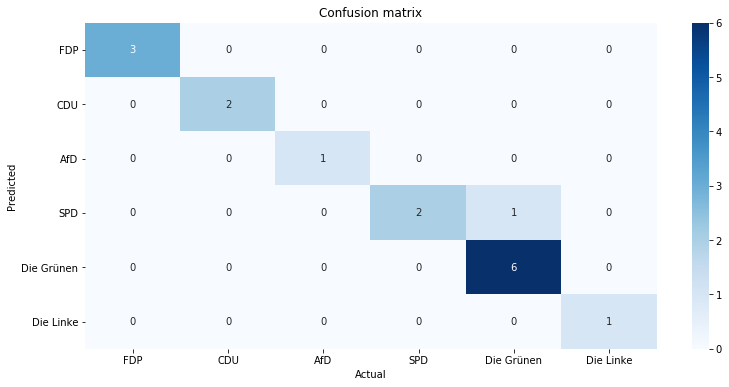

In [246]:
aux_df = programs_df[['party', 'party_code']].drop_duplicates().sort_values('party_code')
conf_matrix = confusion_matrix(labels_test, gbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['party'].values, 
            yticklabels=aux_df['party'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [247]:
base_model = GradientBoostingClassifier(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.875

In [248]:
best_gbc.fit(features_train, labels_train)
accuracy_score(labels_test, best_gbc.predict(features_test))

0.9375

In [249]:
data = {
     'Model': 'Gradient Boosting',
     'Training Set Accuracy': accuracy_score(labels_train, best_gbc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, gbc_pred)
}

models_df_gbc = pd.DataFrame(data, index=[0])
model_summary_df = model_summary_df.append(models_df_gbc)
models_df_gbc

,Model,Training Set Accuracy,Test Set Accuracy
0,Gradient Boosting,1.0,0.9375


In [250]:
with open('Models/best_gbc.pickle', 'wb') as output:
    pickle.dump(best_gbc, output)
    
with open('Models/models_df_gbc.pickle', 'wb') as output:
    pickle.dump(models_df_gbc, output)

## Random Forrest

bisschen bla bla

### Hyperparameter Tuning mittels Cross Validation

In [251]:
rf_init = RandomForestClassifier(random_state = 123)

print('Parameters currently in use:\n')
pprint(rf_init.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}


We'll tune the following ones:
n_estimators = number of trees in the forest.
max_features = max number of features considered for splitting a node
max_depth = max number of levels in each decision tree
min_samples_split = min number of data points placed in a node before the node is split
min_samples_leaf = min number of data points allowed in a leaf node
bootstrap = method for sampling data points (with or without replacement)


### Randomized Search Cross Validation

In [252]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [253]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=123)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=123)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [254]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}

The mean accuracy of a model with these hyperparameters is:
0.9523809523809524


In [255]:
# Create the parameter grid based on the results of random search 
bootstrap = [False]
max_depth = [70, 80, 90]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 3, 4]
n_estimators = [400]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=123)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 123)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   55.3s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=123, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_sam...
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=123,
                                

In [256]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'bootstrap': False, 'max_depth': 70, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}

The mean accuracy of a model with these hyperparameters is:
0.8730158730158729


In [257]:
best_rfc = grid_search.best_estimator_
best_rfc

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=70, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

### Model fit and performance

In [258]:
best_rfc.fit(features_train, labels_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=70, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [259]:
rfc_pred = best_rfc.predict(features_test)
rfc_pred

array([3, 4, 4, 0, 3, 1, 5, 3, 0, 4, 0, 4, 2, 1, 4, 4])

In [260]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_rfc.predict(features_train)))

The training accuracy is: 
1.0


In [261]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, rfc_pred))

The test accuracy is: 
1.0


In [262]:
# Classification report
print("Classification report")
print(classification_report(labels_test,rfc_pred))

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         1

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



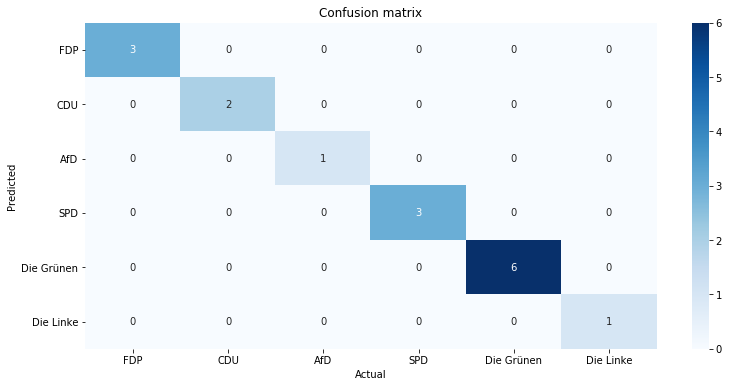

In [263]:
aux_df = programs_df[['party', 'party_code']].drop_duplicates().sort_values('party_code')
conf_matrix = confusion_matrix(labels_test, rfc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['party'].values, 
            yticklabels=aux_df['party'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [264]:
base_model = RandomForestClassifier(random_state = 123)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9375

In [265]:
best_rfc.fit(features_train, labels_train)
accuracy_score(labels_test, best_rfc.predict(features_test))

1.0

In [266]:
data = {
     'Model': 'Random Forest',
     'Training Set Accuracy': accuracy_score(labels_train, best_rfc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, rfc_pred)
}

models_df_rfc = pd.DataFrame(data, index=[0])
model_summary_df = model_summary_df.append(models_df_rfc)
models_df_rfc

,Model,Training Set Accuracy,Test Set Accuracy
0,Random Forest,1.0,1.0


In [267]:
with open('Models/best_rfc.pickle', 'wb') as output:
    pickle.dump(best_rfc, output)
    
with open('Models/models_df_rfc.pickle', 'wb') as output:
    pickle.dump(models_df_rfc, output)

## Zusammenfassung

In [268]:
model_summary_df = model_summary_df.reset_index().drop('index', axis=1).sort_values('Test Set Accuracy', ascending=False)
model_summary_df

,Model,Training Set Accuracy,Test Set Accuracy
5,Random Forest,1.000000,1.0000
0,SVM,1.000000,0.9375
3,Logistic Regression,1.000000,0.9375
4,Gradient Boosting,1.000000,0.9375
2,KNN,0.887097,0.8125
1,Multinomial Naïve Bayes,0.548387,0.2500
